In [1]:
import pandas as pd
import numpy as np
from pickleshare import PickleShareDB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Pour garantir la reproductibilité
np.random.seed(42)  # Pour numpy

## Chargement des données

In [3]:
db = PickleShareDB('../prep_data/kity')
sample_df = db['net_sample_for_models']

Le type d'attaque 'scan' a tres peu d'entrees, ce qui empeche les modeles. On supprime ce type d'attaque.

In [4]:
to_drop = sample_df[sample_df['label'] == 'scan'].index
sample_df = sample_df.drop(to_drop)

In [5]:
labels = sample_df[['label', 'label_n']]
sample_df.drop(columns=['label', 'label_n'], inplace=True)

## Initialisation du modèle

In [6]:
X = sample_df
y_label_n = labels['label_n']
y_label = labels['label']

y_label_n_str = y_label_n.astype(str)
# Encoder les labels en int
le = LabelEncoder()
y_label_n_encoded = le.fit_transform(y_label_n)

ordered_classes = ['normal', 'DoS','physical fault', 'MITM', 'anomaly']
label_map = {label: idx for idx, label in enumerate(ordered_classes)}
y_label_encoded = [label_map[label] for label in y_label]


In [7]:
# Diviser les données en ensembles d'entraînement et de test, pour label_n
X_train_label_n, X_test_label_n, y_train_label_n, y_test_label_n = train_test_split(X, y_label_n_encoded, test_size=0.2, random_state=42, stratify=y_label_n_str)

# Diviser les données en ensembles d'entraînement et de test, pour label
X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X, y_label_encoded, test_size=0.2, random_state=42, stratify=y_label_n_str)

In [8]:
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

In [9]:
# Pour label_n
# Fit the model
xgb_model.fit(X_train_label_n, y_train_label_n)

# Make predictions
y_pred_label_n = xgb_model.predict(X_test_label_n)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [10]:
# Pour label
# Fit the model
xgb_model.fit(X_train_label_n, y_train_label_n)

# Make predictions
y_pred_label = xgb_model.predict(X_test_label_n)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Évaluation

In [12]:
def tpr_tnr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
    return tpr, tnr

### Prédiction pour label

#### Données équilibrées

In [13]:
# Métriques pour les données équilibrées
precision = precision_score(y_test_label_n, y_pred_label_n, average='binary')
recall = recall_score(y_test_label_n, y_pred_label_n, average='binary')
accuracy = accuracy_score(y_test_label_n, y_pred_label_n)
tpr, tnr = tpr_tnr(y_test_label_n, y_pred_label_n)

print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"TPR (Sensibilité) : {tpr:.2f}")
print(f"TNR (Spécificité) : {tnr:.2f}")
print(f"Exactitude (Accuracy) : {accuracy:.2f}")

Précision : 1.00
Rappel : 0.57
TPR (Sensibilité) : 0.57
TNR (Spécificité) : 1.00
Exactitude (Accuracy) : 0.82


#### Données déséquilibrées

In [14]:
# Métriques pour les données déséquilibrées
f1 = f1_score(y_test_label_n, y_pred_label_n, average='binary')
balanced_acc = balanced_accuracy_score(y_test_label_n, y_pred_label_n)
mcc = matthews_corrcoef(y_test_label_n, y_pred_label_n)

print(f"F1-Score : {f1:.2f}")
print(f"Précision équilibrée : {balanced_acc:.2f}")
print(f"Coefficient de Matthews : {mcc:.2f}")

F1-Score : 0.73
Précision équilibrée : 0.78
Coefficient de Matthews : 0.66


#### Matrice de confusion 

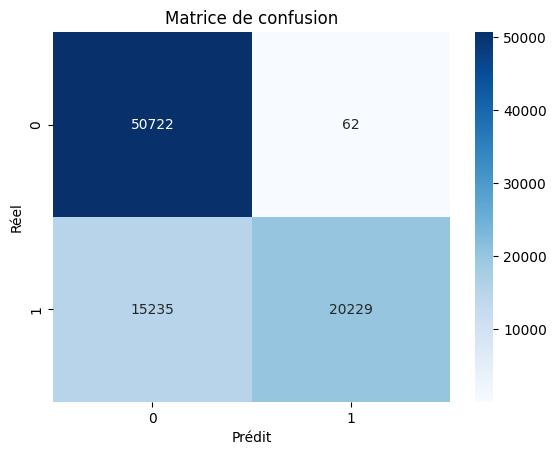

In [15]:
# Matrice de confusion
cm = confusion_matrix(y_test_label_n, y_pred_label_n)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()

### Prédiction pour label

#### Données équilibrées

In [16]:
# Métriques pour les données équilibrées
precision = precision_score(y_test_label, y_pred_label, average='macro')
recall = recall_score(y_test_label, y_pred_label, average='macro')
accuracy = accuracy_score(y_test_label, y_pred_label)

print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"Exactitude (Accuracy) : {accuracy:.2f}")

Précision : 0.35
Rappel : 0.39
Exactitude (Accuracy) : 0.82


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Données déséquilibrées

In [17]:
# Métriques pour les données déséquilibrées
f1 = f1_score(y_test_label, y_pred_label, average='macro')
balanced_acc = balanced_accuracy_score(y_test_label, y_pred_label)
mcc = matthews_corrcoef(y_test_label, y_pred_label)

print(f"F1-Score : {f1:.2f}")
print(f"Précision équilibrée : {balanced_acc:.2f}")
print(f"Coefficient de Matthews : {mcc:.2f}")

F1-Score : 0.37
Précision équilibrée : 0.39
Coefficient de Matthews : 0.69


#### Matrice de confusion 

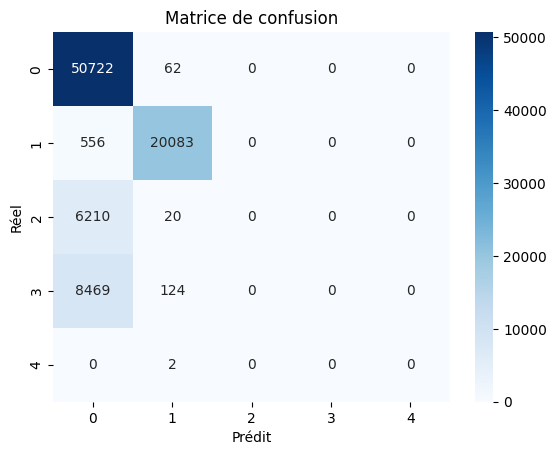

In [18]:
# Matrice de confusion
cm = confusion_matrix(y_test_label, y_pred_label)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()